In [10]:
from torch import nn
from torch.nn import functional as F
import torch
from modules import Swinv2Fields, LayerNorm2D
import torchvision.transforms as T
from transformers import Swinv2Model, Swinv2Config, AutoImageProcessor
from PIL import Image
from utils import ImageSetDataset, grid_mapping, normalize_coord
from einops import rearrange, repeat
import numpy as np

In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
sample_path = './images/test.jpg'
checkpoint_path = '../pretraining-single-image-swin-v2.pth'
INPUT_SIZE = 256
SWIN_PRETRAINED = "microsoft/swinv2-base-patch4-window8-256"
UPSAMPLE_SCALAR = 8 # the upsample factor for basises
MAX_RESOLUTION = 512 # for input to Coeff and Basis, the images would be B, 3, INPUT_SIZE, INPUT_SIZE. For Sampling it would be INPUT_SIZE to MAX_RESOLUTION

In [3]:
pretrained_model = Swinv2Model.from_pretrained(SWIN_PRETRAINED)
config = Swinv2Config(image_size = INPUT_SIZE, 
                    patch_size = pretrained_model.config.patch_size,
                    num_channels = pretrained_model.config.num_channels,
                    embed_dim = pretrained_model.config.embed_dim,
                    depths = [2, 2, 4, 2, 2, 2], 
                    num_heads = [4, 8, 16, 32, 64, 128],
                    window_size = pretrained_model.config.window_size,
                    mlp_ratio = pretrained_model.config.mlp_ratio, 
                    qkv_bias = pretrained_model.config.qkv_bias, 
                    hidden_dropout_prob = pretrained_model.config.hidden_dropout_prob, 
                    attention_probs_dropout_prob = pretrained_model.config.attention_probs_dropout_prob, 
                    pretrained_window_sizes = [0] * 6,
                    drop_path_rate = pretrained_model.config.drop_path_rate, 
                    hidden_act = pretrained_model.config.hidden_act,
                    initializer_range = pretrained_model.config.initializer_range,
                    layer_norm_eps = pretrained_model.config.layer_norm_eps,
                    use_absolute_embeddings = pretrained_model.config.use_absolute_embeddings,
                    )
model = Swinv2Model(config)
basis_field = Swinv2Fields(swin = model, freq_bands_num = 6, freq_sizes = [8, 8, 8, 8, 4, 2], upsample_scalar = UPSAMPLE_SCALAR, output_mlp_ratio = 2)
coeff_config = Swinv2Config(image_size = INPUT_SIZE, 
                    patch_size = pretrained_model.config.patch_size,
                    num_channels = pretrained_model.config.num_channels,
                    embed_dim = pretrained_model.config.embed_dim,
                    depths = [2, 8], 
                    num_heads = [4, 8],
                    window_size = pretrained_model.config.window_size,
                    mlp_ratio = pretrained_model.config.mlp_ratio, 
                    qkv_bias = pretrained_model.config.qkv_bias, 
                    hidden_dropout_prob = pretrained_model.config.hidden_dropout_prob, 
                    attention_probs_dropout_prob = pretrained_model.config.attention_probs_dropout_prob, 
                    pretrained_window_sizes = [0] * 2,
                    drop_path_rate = pretrained_model.config.drop_path_rate, 
                    hidden_act = pretrained_model.config.hidden_act,
                    initializer_range = pretrained_model.config.initializer_range,
                    layer_norm_eps = pretrained_model.config.layer_norm_eps,
                    use_absolute_embeddings = pretrained_model.config.use_absolute_embeddings,
                )
coeff_field = Swinv2Model(coeff_config)
coeff_decoder = nn.Sequential(
    nn.Conv2d(in_channels = coeff_field.encoder.layers[-1].dim, out_channels = sum(basis_field.basis_output_hidden_size), kernel_size = 3, padding = 1),
    LayerNorm2D(normalized_shape = sum(basis_field.basis_output_hidden_size)),
    nn.Conv2d(in_channels = sum(basis_field.basis_output_hidden_size), out_channels = sum(basis_field.basis_output_hidden_size), kernel_size = 1, padding = 0)
)
mat = nn.Sequential(
        nn.Conv2d(kernel_size = 7, in_channels = sum(basis_field.basis_output_hidden_size), out_channels = 256, padding = 3),
        LayerNorm2D(normalized_shape = 256),
        nn.Conv2d(kernel_size = 1, in_channels = 256, out_channels = 128, padding = 0),
        nn.ReLU(),
        nn.Conv2d(kernel_size = 7, in_channels = 128, out_channels = 128, padding = 3),
        LayerNorm2D(normalized_shape = 128),
        nn.Conv2d(kernel_size = 1, in_channels = 128, out_channels = 64, padding = 0),
        nn.ReLU(),
        nn.Conv2d(kernel_size = 1, in_channels = 64, out_channels = 3, padding = 0),
)

/home/jkarly/anaconda3/envs/gsplat/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Frequency bands: [1, 2, 4, 8, 16, 32], Frequency sizes: [8, 8, 8, 8, 4, 2], Output sizes: [64, 32, 16, 8, 4, 2], Basis hidden sizes: [1024, 1024, 1024, 1024, 2048, 4096], Basis output hidden sizes: [32, 32, 32, 32, 64, 128]


In [4]:
preprocess = T.Compose([
                            T.Resize(MAX_RESOLUTION),
                            T.ToTensor(),
                            T.CenterCrop((MAX_RESOLUTION, MAX_RESOLUTION)),
                        ])
transform = T.Compose([
                        T.Resize(size = (INPUT_SIZE, INPUT_SIZE)),
                    ])

In [5]:
sample = Image.open(sample_path)
target = preprocess(sample).unsqueeze(0)
pixel_values = transform(target)
target.shape, pixel_values.shape

/home/jkarly/anaconda3/envs/gsplat/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 256, 256]))

In [6]:
checkpoint = torch.load(checkpoint_path, map_location = 'cpu')
basis_field.load_state_dict(checkpoint['basis_field'])
coeff_field.load_state_dict(checkpoint['coeff_field'])
coeff_decoder.load_state_dict(checkpoint['coeff_decoder'])
mat.load_state_dict(checkpoint['mat'])

<All keys matched successfully>

In [7]:
y, x = torch.meshgrid(torch.arange(0, MAX_RESOLUTION), torch.arange(0, MAX_RESOLUTION), indexing = 'ij')
coords_original = torch.stack([x, y], dim = -1) + 0.5 # H, W, 2
coords_original = coords_original.unsqueeze(0)

In [8]:
basis_field.eval().to(device)
coeff_field.eval().to(device)
coeff_decoder.eval().to(device)
mat.eval().to(device)
coords_original = coords_original.to(device)
pixel_values = pixel_values.to(device)
target = target.to(device)

In [14]:
with torch.no_grad():
    _, basises = basis_field(imgs = pixel_values)
    coeff_embeddings = coeff_field(pixel_values = pixel_values).last_hidden_state
    coeff = coeff_decoder(rearrange(coeff_embeddings, 'b (h w) c -> b c h w', h = int(coeff_embeddings.shape[1] ** 0.5), w = int(coeff_embeddings.shape[1] ** 0.5)))
    coeff_sampled = F.grid_sample(coeff, grid = normalize_coord(coords_original, aabb = coords_original.new([[0, 0], [MAX_RESOLUTION, MAX_RESOLUTION]])),
                                        align_corners = False, mode = 'bilinear', padding_mode = 'border')

    basis_coords = grid_mapping(coords_original, aabb = coords_original.new([[0, 0], [MAX_RESOLUTION, MAX_RESOLUTION]]), 
                                freq_bands = coords_original.new(basis_field.freq_bands))
    basis_list = []

    for idx, fi in enumerate(basises):

        basis = F.grid_sample(fi, grid = basis_coords[..., idx], align_corners = False, mode = 'bilinear', padding_mode = 'border')
        basis_list.append(basis)

    basises = torch.cat(basis_list, dim = 1)
    assert basises.shape == coeff_sampled.shape
    feat = coeff_sampled * basises
    rgb = mat(feat)
    print(F.mse_loss(rgb, target).item(), 'PSNR:', 10 * torch.log10(1 / F.mse_loss(rgb, target)).item())

0.0003272663743700832 PSNR: 34.85098838806152


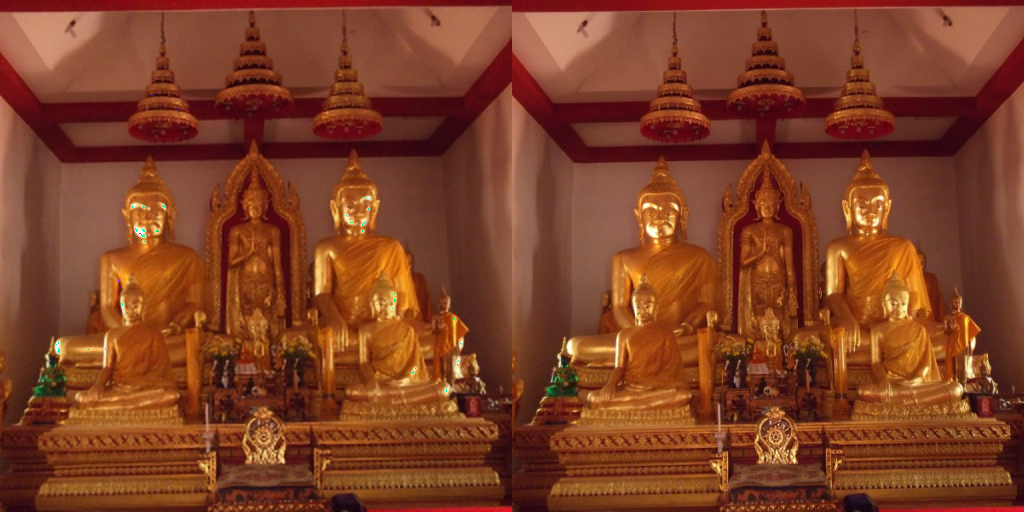

In [15]:
Image.fromarray((torch.cat((rgb[0], target[0]), dim = 2).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8))